# Ailsa Craig

Ailsa Craig is a small island in the outer Firth of Clyde, 16 kilometres west of mainland Scotland. <br>
Important for our analysis that Ailsa Craig has a cliff on the south-west side.
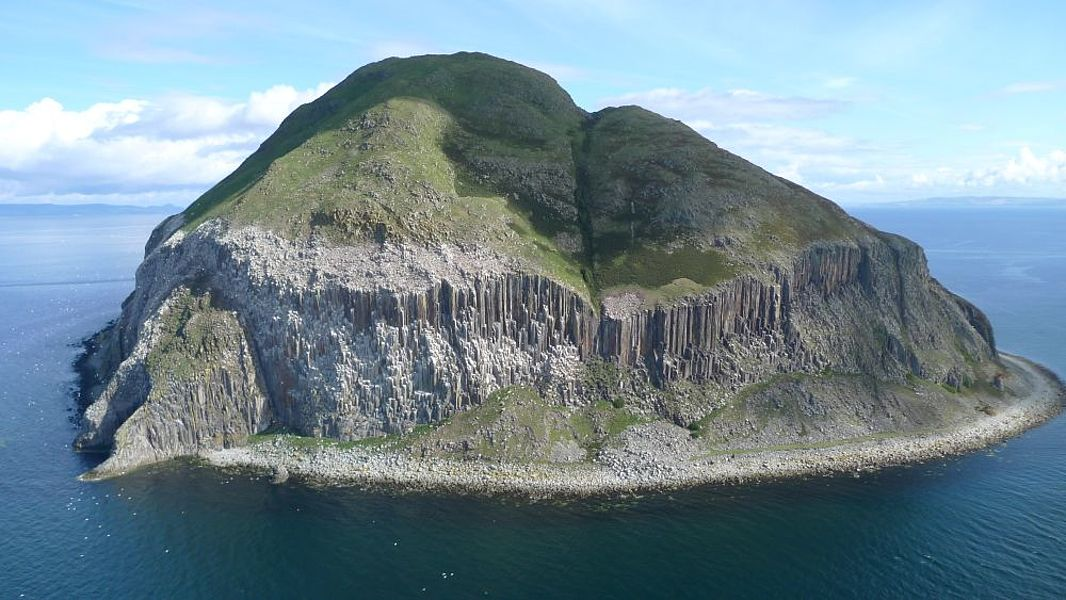

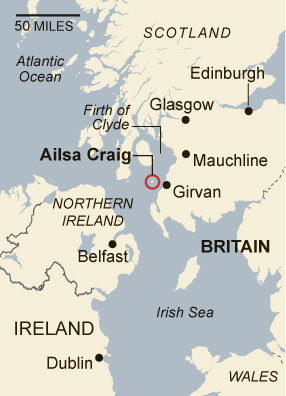

### Topography Ailsa Craig

In [ ]:
# Install colour maps
%pip install cmocean

# Import all the necessary libraries
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import folium
import cmocean as cmo
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,10)

In [ ]:
# Reading in the data
elevation_A = np.loadtxt('AilsaCraig.txt')

In [ ]:
# Topography plot
fig, ax = plt.subplots()
plt.imshow(elevation_A[95:165, 95:165], origin='lower')
plt.title("Topography plot of Ailsa Craig", fontsize = 15)
plt.xlabel("Distance from origin in easterly direction [m]", fontsize = 13)
plt.ylabel("Distance from origin in northerly direction [m]", fontsize = 13)

# the island is surrounded by the sea
# is quite a pixelated plot

In [ ]:
# Contour plot of North Berwick and Berwick Law
fig, ax = plt.subplots()

CS = ax.contour(elevation_A[95:165, 95:165])

ax.clabel(CS, inline=1, fontsize=8, fmt='%1.f')
ax.set_title('Contour plot of Ailsa Craig', fontsize = 15)
ax.set_xlabel("Distance from origin in easterly direction [m]", fontsize = 13)
ax.set_ylabel("Distance from origin in northerly direction [m]", fontsize = 13)

# Annotate the cliff location
ax.annotate('Cliff', xy=(20, 13),
             xycoords='data',
             xytext=(10, 10),
             fontsize = 15,
             textcoords='data',
             arrowprops=dict(arrowstyle= '->', color='black', lw=2))

plt.show()

In [ ]:
# Another way of using plot_surface

# Import data
fig = plt.figure(figsize=(20, 12))
ax = fig.gca(projection='3d')


# Scaling of the z-axis to make the plot less spiky and more realistic
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))

# Define meshgrid and make data
elevation_sub = elevation_A[95:165, 95:165]
n=len(elevation_sub)
X = np.arange(0, n, 1)
Y = np.arange(0, n, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
B = elevation_sub[X,Y]

# Plot the surface
ax.plot_surface(X, Y, B, cmap= cmo.cm.solar, rcount=50, ccount=100)
#ax.plot_surface(X, Y, B,rcount=50, ccount=100) # without color map
# deep, topo, balance, amp, turbid, solar
# I prefer solar or balance or deep

# Set axes labels
ax.set_xlabel("Distance from origin in easterly direction [m]", fontsize = 13)
ax.set_ylabel("Distance from origin in northerly direction [m]", fontsize = 13)

fig.tight_layout()

In [ ]:
## Field work suggestions
# Need to add more locations, measurement 1 is an example

# Create the basemap
loc = [55.25, -5.11] # Coordinates of Edinburgh
m1 = folium.Map(location=loc, # Map centred at Ailsa Craig
                tiles='OpenStreetMap', 
                zoom_start=17) # Zoomed in to show central Edinburgh

# Add pop-up showing the coordinates when clicking anywhere on the map
m1.add_child(folium.LatLngPopup())

# Add a marker at Argyle House (Noteable's offices)
#tooltip = 'Click me!'
#locationName = 'Measurement 1' # Text for pop-up
#workloc = [ 56.0480, -2.7166] # Coordinates of Measurement 1
#folium.Marker(workloc, popup=locationName).add_to(m1) # Add the marker to basemap
display(m1)

# do we want to give suggestions for fieldworkd?

## Wind Ailsa Craig

In [ ]:
## Calculate wind
# Parameters
topo_file_A = 'AilsaCraig.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file_A)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)

# Vertical wind component from continuity equation
w = np.zeros_like(wind)
dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
w[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + v[1:-1,1:-1]*dzdy

In [ ]:
# Wind vector plot over hill

X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 10))
#create quiver plot of data

q = ax.quiver(X[95:165], Y[95:165], u[95:165, 95:165], v[95:165, 95:165], wind[95:165, 95:165], cmap='viridis_r', pivot='mid', units='inches')

# set colourbar for the plot
cbar = fig.colorbar(q)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

ax.set_title("Wind vector plot over Ailsa Craig", fontsize = 13)
ax.set_xlabel("East direction", fontsize=12)
ax.set_ylabel("North direction", fontsize=12)
plt.show()

# if we use the plots from different hills next to each other
# we should couple the color bars as it is confusing otherwise

# zoom in 

In [ ]:
X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 10))
#create quiver plot of data

q = ax.quiver(X[95:180], Y[95:180], u[95:180, 95:180], v[95:180, 95:180], wind[95:180, 95:180], cmap='viridis_r', pivot='mid', units='inches')

# set colourbar for the plot
cbar = fig.colorbar(q)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

extent = (100, 120, 100, 120)

# Define position of the zoomed-in plot
axins = zoomed_inset_axes(ax, 1.2, loc=1)
axins.quiver(X[100:120], Y[100:120], u[100:120, 100:120], v[100:120, 100:120], wind[100:120, 100:120], cmap='viridis_r', pivot='mid', units='inches')
axins.set_xlim(100, 120)
axins.set_ylim(100, 120)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Set to false, so that x and yticks are not shown
plt.xticks(visible=False)
plt.yticks(visible=False)

## does not look good 

In [ ]:
# Wind stream lines over hill

#create stream plot

fig, ax = plt.subplots(figsize=(12, 10))
strm = ax.streamplot(X[95:165], Y[95:165], u[95:165, 95:165], v[95:165, 95:165], color=wind[95:165, 95:165], cmap='viridis_r')

#set colourbar according to wind speed
cbar = fig.colorbar(strm.lines)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

ax.set_title("Wind stream lines over Ailsa Craig", fontsize = 13)
ax.set_xlabel("East direction", fontsize = 12)
ax.set_ylabel("North direction", fontsize = 12)

plt.show()

In [ ]:
# Wind speed over top of hill
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(wind[128,:], c = "k")
ax.set_title("Wind speed over Ailsa Craig", fontsize = 13)
ax.set_xlabel("Distance [m]", fontsize = 12)
ax.set_ylabel("Wind speed [ms$^{-1}$]", fontsize = 12)
ax.grid()

## Plotting vertical component of wind

In [ ]:
# Plot vertical wind component and topography for 1 km x 1 km area centred on the summit
fig, ax = plt.subplots(figsize=(12,8))

plt.imshow(w[95:165, 95:165],origin='lower', aspect='auto')  # north at the top of the image
plt.colorbar()
cs = plt.contour(z[95:165, 95:165],colors='k',levels=np.arange(0,1000,20))
plt.clabel(cs,fmt='%d')
plt.xticks([])
plt.yticks([])
plt.title("Vertical wind component over summit of Ailsa Craig")

## 3D wind speed plot

In [ ]:
# Wind speed 3d plot around the hill

from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

#%matplotlib notebook
def surface_plot(data):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, 50)
    y = np.arange(0, 50)
    X, Y = np.meshgrid(x, y)

    # Normalize to [0,1]
    Z = data[100:150, 100:150]
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis_r(norm(Z))
    rcount, ccount, _ = colors.shape
    

    surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                           facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    


    ax.set_xlabel('Distance from origin in east direction [m]', fontsize=13)
    ax.set_ylabel('Distance from origin in north direction [m]', fontsize=13)
    ax.set_zlabel('Wind speed [m s$^{-1}$]', fontsize=13)
    plt.xticks(np.arange(0, 50, step=10), labels=[0,250,500,750,1000])
    plt.yticks(np.arange(0, 50, step=10), labels=[0,250,500,750,1000])
    #ax.set_title("3D plot of wind speed around North Berwick Law", fontsize=14)
    #ax.view_init(30, 110) # change the viewing angle
    
surface_plot(wind)

# I would not include this plot as it is too messy

In [ ]:
# 3D plot of Vertical wind speed component (w)

surface_plot(w)

## interesting as there is a cliff in the lowrt right corner
# we can analyse the limitations of the model (ie does not work for cliffs)

# Wind from other direction

## Note, the plots below are correct but they are not rotated such that North is at the top of the image

In [ ]:
## Calculate wind
# Parameters
topo_file_A = 'AilsaCraig.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)


# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

def wind_model(z):
    """
    Function to calculate the wind components and overal wind
    Input: Topography file to be read in
    Output: Wind components and overal wind
    """
    
    # Iteration to find the inner region thickness l (m)
    l = (z0/8)*(L/z0)**0.9
    for i in range(10):
        l = 2*0.16*L/np.log(l/z0)
    a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

    # Find size and take a Fourier transform
    n = z.shape[0]
    Fz = fft2(z)
    Fz = fftshift(Fz)

    # Wavenumbers and modified Bessel functions
    k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
    m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
    bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
    bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
    bu[int(n/2)] = 0
    bv[int(n/2)] = 0

    # Fourier components of u and v
    Fu = np.zeros_like(Fz)
    Fv = np.zeros_like(Fz)
    for i in range(n):
        for j in range(n):
            r = np.sqrt(k[j]**2 + m[i]**2)
            if r != 0:
                Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
                Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

    # Inverse Fourier transform
    Fu = ifftshift(Fu)
    Fv = ifftshift(Fv)
    u = 1 + np.real(ifft2(Fu))
    v = np.real(ifft2(Fv))
    wind = np.sqrt(u**2 + v**2)

    # Vertical wind component from continuity equation
    w = np.zeros_like(wind)
    dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
    dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
    w[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + v[1:-1,1:-1]*dzdy
    
    return u, v, w, wind

In [ ]:
# Vertical wind component plots for wind coming from different directions
z = np.loadtxt(topo_file_A)
z1 = (np.flipud(z)).T
z2 = np.flipud(np.fliplr(z))
z3 = np.flipud(z.T)

z_list = [z1[95:165, 95:165], z2[95:165, 95:165], z3[95:165, 95:165], z[95:165, 95:165]]
directions = ["Northerly", "Easterly", "Southerly", "Westerly"]
cardinal_dir = ["East", "South", "West", "North", "East"]

for i in range(0,4):
    plt.subplot(2,2,i+1)
    #z_list[i] = np.rot90(z_list[i], k = i+1)
    u, v, w, wind = wind_model(z_list[i])
    plt.imshow(w,origin='lower', aspect='auto')
    CS = plt.contour(z_list[i],colors='k',levels=np.arange(0,1000,20))
    plt.clabel(CS,fmt='%d')
    plt.title(directions[i]+" wind")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(cardinal_dir[i+1])
    plt.ylabel(cardinal_dir[i])
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
plt.suptitle("Vertical wind component over Ailsa Craig", fontsize = 13)
plt.show()
# add color bar and better to rotate the plots
# more efficient if calculate u, v, w, wind once for all plot?

In [ ]:
# Stream plots for wind from different directions 
X = np.arange(0, 256)
Y = np.arange(0, 256)

for i in range(0,4):
    plt.subplot(2,2,i+1)
    u, v, w, wind = wind_model(z_list[i])
    strm = plt.streamplot(X[95:165], Y[95:165], u, v, color=wind, cmap='viridis_r')
    plt.title(directions[i]+" wind")
    plt.xlabel(cardinal_dir[i+1])
    plt.ylabel(cardinal_dir[i])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.locator_params(nbins=7)

plt.suptitle("Wind stream lines over Ailsa Craig", fontsize = 13)
plt.show()

# add one colorbar, which is the same for all plots
# rotate plots

In [ ]:
# Wind vector plot for different wind directions 
for i in range(0,4):
    plt.subplot(2,2,i+1)
    u, v, w, wind = wind_model(z_list[i])
    plt.quiver(X[95:165], Y[95:165], u, v, wind, cmap='viridis_r', pivot='mid', units='inches')
    plt.title(directions[i]+" wind")
    plt.xlabel(cardinal_dir[i+1])
    plt.ylabel(cardinal_dir[i])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.locator_params(nbins=7)

plt.suptitle("Wind vectors over Ailsa Craig", fontsize = 13)
plt.show()

In [ ]:
# Define 3 subplots to show each wind plot type for each different wind direciton

def tripple_plot(z, x_dir, y_dir, title):
    u, v, w, wind = wind_model(z)
    X = np.arange(0, 256)
    Y = np.arange(0, 256)
    
    fig = plt.figure(figsize = (20, 6))
    ax = fig.add_subplot(131)
    ax.imshow(w[95:165, 95:165],origin='lower', aspect='auto')
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()
    cs = plt.contour(z[95:165, 95:165],colors='k',levels=np.arange(0,1000,20))
    plt.clabel(cs,fmt='%d')
    ax.set_title("Vertical wind component")
    ax.set_xlabel(x_dir, fontsize = 12)
    ax.set_ylabel(y_dir, fontsize = 12)

    ax2 = fig.add_subplot(132)
    strm = plt.streamplot(X[95:165], Y[95:165], u[95:165, 95:165], v[95:165, 95:165], color=wind[95:165, 95:165], cmap='viridis_r')
    #cbar = fig.colorbar(strm.lines)
    #cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)
    plt.xticks([])
    plt.yticks([])
    ax2.set_title("Wind stream lines", fontsize = 13)
    ax2.set_xlabel(x_dir, fontsize = 12)
    ax2.set_ylabel(y_dir, fontsize = 12)


    ax3 = fig.add_subplot(133)
    q = plt.quiver(X[95:165], Y[95:165], u[95:165, 95:165], v[95:165, 95:165], wind[95:165, 95:165], cmap='viridis_r', pivot='mid', units='inches')
    #cbar = fig.colorbar(q)
    #cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)
    plt.xticks([])
    plt.yticks([])
    ax3.set_title("Wind vector plot", fontsize = 13)
    ax3.set_xlabel(x_dir, fontsize=12)
    ax3.set_ylabel(y_dir, fontsize=12)
    
    plt.suptitle(title, fontsize = 15)
    
    plt.show()

In [ ]:
z = np.loadtxt(topo_file_A)
tripple_plot(z = z, x_dir = "East", y_dir = "North", 
             title = "Westerly wind over Ailsa Craig")


In [ ]:
z1 = (np.flipud(z)).T
tripple_plot(z = z1, x_dir = "South", y_dir = "East", 
             title = "Northerly wind over Ailsa Craig")

In [ ]:
z2 = np.flipud(np.fliplr(z))
tripple_plot(z = z2, x_dir = "West", y_dir = "South", 
            title = "Easterly wind over Ailsa Craig")

In [ ]:
z3 = np.flipud(z.T)
tripple_plot(z = z3, x_dir = "North", y_dir = "West",
            title = "Southerly wind over Ailsa Craig")

# Winds from different directions

## Plots are rotated such that North is at the top of the image

In [ ]:
## Define a function which calculates the u and v component and wind

def wind_model(n,zr):
    """
    Function to calculate the wind components and overal wind
    Input: 
    - n: n = zr.shape[0]
    - zr: Topography file to be read in
    Output: Wind components and overal wind
    """
    
    # Fourier transform
    Fz = fft2(zr)
    Fz = fftshift(Fz)
    
    # Wavenumbers and modified Bessel functions
    k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
    m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
    bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
    bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
    bu[int(n/2)] = 0
    bv[int(n/2)] = 0
    
    # Fourier components of u and v
    Fu = np.zeros_like(Fz)
    Fv = np.zeros_like(Fz)
    for i in range(n):
        for j in range(n):
            r = np.sqrt(k[j]**2 + m[i]**2)
            if r>0:
                Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
                Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]
    
    # Inverse Fourier transform
    Fu = ifftshift(Fu)
    Fv = ifftshift(Fv)
    ur = 1 + np.real(ifft2(Fu))
    vr = np.real(ifft2(Fv))
    windr = np.sqrt(ur**2 + vr**2)
    return ur,vr,windr

In [ ]:
# Define a function to plot the streamplot and the contour lines

def plot_wind(u,v,wind,z,title):
    """
    Input:
    - u, v: wind components
    - wind: overall wind
    - z: topography 
    - title: title of the plot
    Output  Plots streamsplot and topography
    """
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.streamplot(x[95:161],y[95:161],u[95:161,95:161],v[95:161,95:161],
                   color=wind[95:161,95:161],linewidth = 2.2, cmap='viridis_r')
    plt.colorbar()
    plt.clim(0, 7)
    cs = plt.contour(x[95:161],y[95:161],z[95:161,95:161],alpha = 0.5, colors='k')
    #plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

In [ ]:
# Use the functions to generate 4 subplots for the different wind directions

"""
The topography is rotated 
- by 90 degrees clockwise with np.flipud(A.T), 
- by 90 degrees anticlockwise with np.fliplr(A.T),
- by 180 degrees with np.flipud(np.fliplr(A.T))

The inverse of the rotation applied to the topography has to be applied to the separate wind components.
The u and v components also have to be swapped for 90 degree rotations.
"""

plt.figure(figsize=(13, 11))

# Westerly wind
plt.subplot(221)
u, v, wind = wind_model(n,z)
plot_wind(u,v,wind,z,'Westerly wind')

# Southerly wind
plt.subplot(222)
zr = np.flipud(z.T)
ur, vr, windr = wind_model(n,zr)
u = - np.fliplr(vr.T)
v = np.fliplr(ur.T)
wind = np.fliplr(windr.T)
plot_wind(u,v,wind,z,'Southerly wind')

# Easterly wind
plt.subplot(223)
zr = np.flipud(np.fliplr(z))
ur, vr, windr = wind_model(n,zr)
u = - np.flipud(np.fliplr(ur))
v = - np.flipud(np.fliplr(vr))
wind = np.flipud(np.fliplr(windr))
plot_wind(u,v,wind,z,'Easterly wind')

# Northerly wind
plt.subplot(224)
zr = np.fliplr(z.T)
ur, vr, windr = wind_model(n,zr)
u = np.flipud(vr.T)
v = - np.flipud(ur.T)
wind = np.flipud(windr.T)
plot_wind(u,v,wind,z,'Northerly wind')

plt.suptitle("Stream plot of different winds over Ailsa Craig", fontsize = 15)
plt.tight_layout()

In [ ]:
### Define a function to plot the streamplot and the contour lines

def quiver_wind(u,v,wind,z,title):
    """
    Input:
    - u, v: wind components
    - wind: overall wind
    - z: topography 
    - title: title of the plot
    Output  Plots streamsplot and topography
    """
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.quiver(x[95:161],y[95:161],u[95:161,95:161],v[95:161,95:161], wind[95:161,95:161], linewidth = 30, 
               cmap='viridis_r', pivot='mid', units='inches')
    plt.colorbar()
    plt.clim(0, 7)
    cs = plt.contour(x[95:161],y[95:161],z[95:161,95:161],alpha = 0.5, colors='k')
    plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

In [ ]:
plt.figure(figsize=(13, 11))

# Westerly wind
plt.subplot(221)
u, v, wind = wind_model(n,z)
quiver_wind(u,v,wind,z,'Westerly wind')

# Southerly wind
plt.subplot(222)
zr = np.flipud(z.T)
ur, vr, windr = wind_model(n,zr)
u = - np.fliplr(vr.T)
v = np.fliplr(ur.T)
wind = np.fliplr(windr.T)
quiver_wind(u,v,wind,z,'Southerly wind')

# Easterly wind
plt.subplot(223)
zr = np.flipud(np.fliplr(z))
ur, vr, windr = wind_model(n,zr)
u = - np.flipud(np.fliplr(ur))
v = - np.flipud(np.fliplr(vr))
wind = np.flipud(np.fliplr(windr))
quiver_wind(u,v,wind,z,'Easterly wind')

# Northerly wind
plt.subplot(224)
zr = np.fliplr(z.T)
ur, vr, windr = wind_model(n,zr)
u = np.flipud(vr.T)
v = - np.flipud(ur.T)
wind = np.flipud(windr.T)
quiver_wind(u,v,wind,z,'Northerly wind')

plt.suptitle("Quiver plot of different winds over Ailsa Craig", fontsize = 15)
plt.tight_layout()

## WindNinja model

In [ ]:
# Define function using the Ninja model output

def Ninja_plots(z, u, v, title, col_bar_min, col_bar_max):
    """
    Input:
    - z: elevation file
    - u and v: wind components
    - title: title for subplot
    - col_bar_min and _max: min and max of colorbar (to ensure that colorbar are the same for subplots)
    
    Output: plots a streamplot with the streamlines colored in by wind speed
    """
    wind = np.sqrt(u**2 + v**2)
    
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.streamplot(x[95:161],y[95:161],u[95:161,95:161],v[95:161,95:161],
                   color=wind[95:161,95:161],cmap='viridis_r')
    plt.colorbar()
    plt.clim(col_bar_min, col_bar_max)
    cs = plt.contour(x[95:161],y[95:161],z[95:161,95:161],alpha = 0.7, colors='k')
    plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

In [ ]:
# Plot wind coming from N, E, S, W

z = np.loadtxt('AilsaCraig.txt')
dx = 25

plt.figure(figsize=(13, 11))
# Westerly wind
plt.subplot(221)
vel = np.loadtxt('AilsaCraig_270_1_25m_vel_2m.asc',skiprows=6)
ang = np.loadtxt('AilsaCraig_270_1_25m_ang_2m.asc',skiprows=6)
u = - vel*np.sin(np.radians(ang))
v = vel*np.cos(np.radians(ang))
Ninja_plots(z, u, v, "Westerly wind", col_bar_min = 0.5, col_bar_max=6)

# Southerly wind
plt.subplot(222)
vel = np.loadtxt('AilsaCraig_180_1_25m_vel_2m.asc',skiprows=6)
ang = np.loadtxt('AilsaCraig_180_1_25m_ang_2m.asc',skiprows=6)
u = vel*np.sin(np.radians(ang))
v = - vel*np.cos(np.radians(ang))
Ninja_plots(z, u, v, "Southerly wind", col_bar_min = 0.5, col_bar_max=6)

# Easterly wind
plt.subplot(223)
vel = np.loadtxt('AilsaCraig_90_1_25m_vel_2m.asc',skiprows=6)
ang = np.loadtxt('AilsaCraig_90_1_25m_ang_2m.asc',skiprows=6)
u = - vel*np.sin(np.radians(ang))
v = vel*np.cos(np.radians(ang))
Ninja_plots(z, u, v, "Easterly wind", col_bar_min = 0.5, col_bar_max=6)

# Northerly wind
plt.subplot(224)
vel = np.loadtxt('AilsaCraig_0_1_25m_vel_2m.asc',skiprows=6)
ang = np.loadtxt('AilsaCraig_0_1_25m_ang_2m.asc',skiprows=6)
u = vel*np.sin(np.radians(ang))
v = - vel*np.cos(np.radians(ang))
Ninja_plots(z, u, v, "Northerly wind", col_bar_min = 0.5, col_bar_max=6)

plt.suptitle("Wind Ninja model: Different winds over Ailsa Craig", fontsize = 15)
plt.tight_layout()

# make so that it reads in in function
# are the minuses correct?

In [ ]:
# Plot wind coming from SE, SW, NW, NE

z = np.loadtxt('AilsaCraig.txt')
dx = 25

plt.figure(figsize=(13, 11))
# South-easterly wind
plt.subplot(221)
vel = np.loadtxt('AilsaCraig_135_1_25m_vel_2m.asc',skiprows=6)
ang = np.loadtxt('AilsaCraig_135_1_25m_ang_2m.asc',skiprows=6)
u = - vel*np.sin(np.radians(ang))
v = - vel*np.cos(np.radians(ang))
Ninja_plots(z, u, v, "South-easterly wind", col_bar_min = 0.2, col_bar_max=2)

# South-westerly wind
plt.subplot(222)
vel = np.loadtxt('AilsaCraig_225_1_25m_vel_2m.asc',skiprows=6)
ang = np.loadtxt('AilsaCraig_225_1_25m_ang_2m.asc',skiprows=6)
u = - vel*np.sin(np.radians(ang))
v = - vel*np.cos(np.radians(ang))
Ninja_plots(z, u, v, "South-westerly wind", col_bar_min = 0.2, col_bar_max=2)

# North-easterly wind
plt.subplot(223)
vel = np.loadtxt('AilsaCraig_45_1_25m_vel_2m.asc',skiprows=6)
ang = np.loadtxt('AilsaCraig_45_1_25m_ang_2m.asc',skiprows=6)
u = - vel*np.sin(np.radians(ang))
v = - vel*np.cos(np.radians(ang))
Ninja_plots(z, u, v, "North-easterly wind", col_bar_min = 0.2, col_bar_max=2)

# North-westerly wind
plt.subplot(224)
vel = np.loadtxt('AilsaCraig_315_1_25m_vel_2m.asc',skiprows=6)
ang = np.loadtxt('AilsaCraig_315_1_25m_ang_2m.asc',skiprows=6)
u = - vel*np.sin(np.radians(ang))
v = - vel*np.cos(np.radians(ang))
Ninja_plots(z, u, v, "North-westerly wind", col_bar_min = 0.2, col_bar_max=2)

plt.suptitle("Wind Ninja model: Different winds over Ailsa Craig", fontsize = 15)
plt.tight_layout()

# make so that it reads in in function
# are the minuses correct?
# is the wind speed actually in m/s as in the google plot it is converted to mph

## Google maps visualizations

Vector plot showing wind over Ailsa Craig <br>
**Note: The wind speed shows is in mph!**

Southerly wind
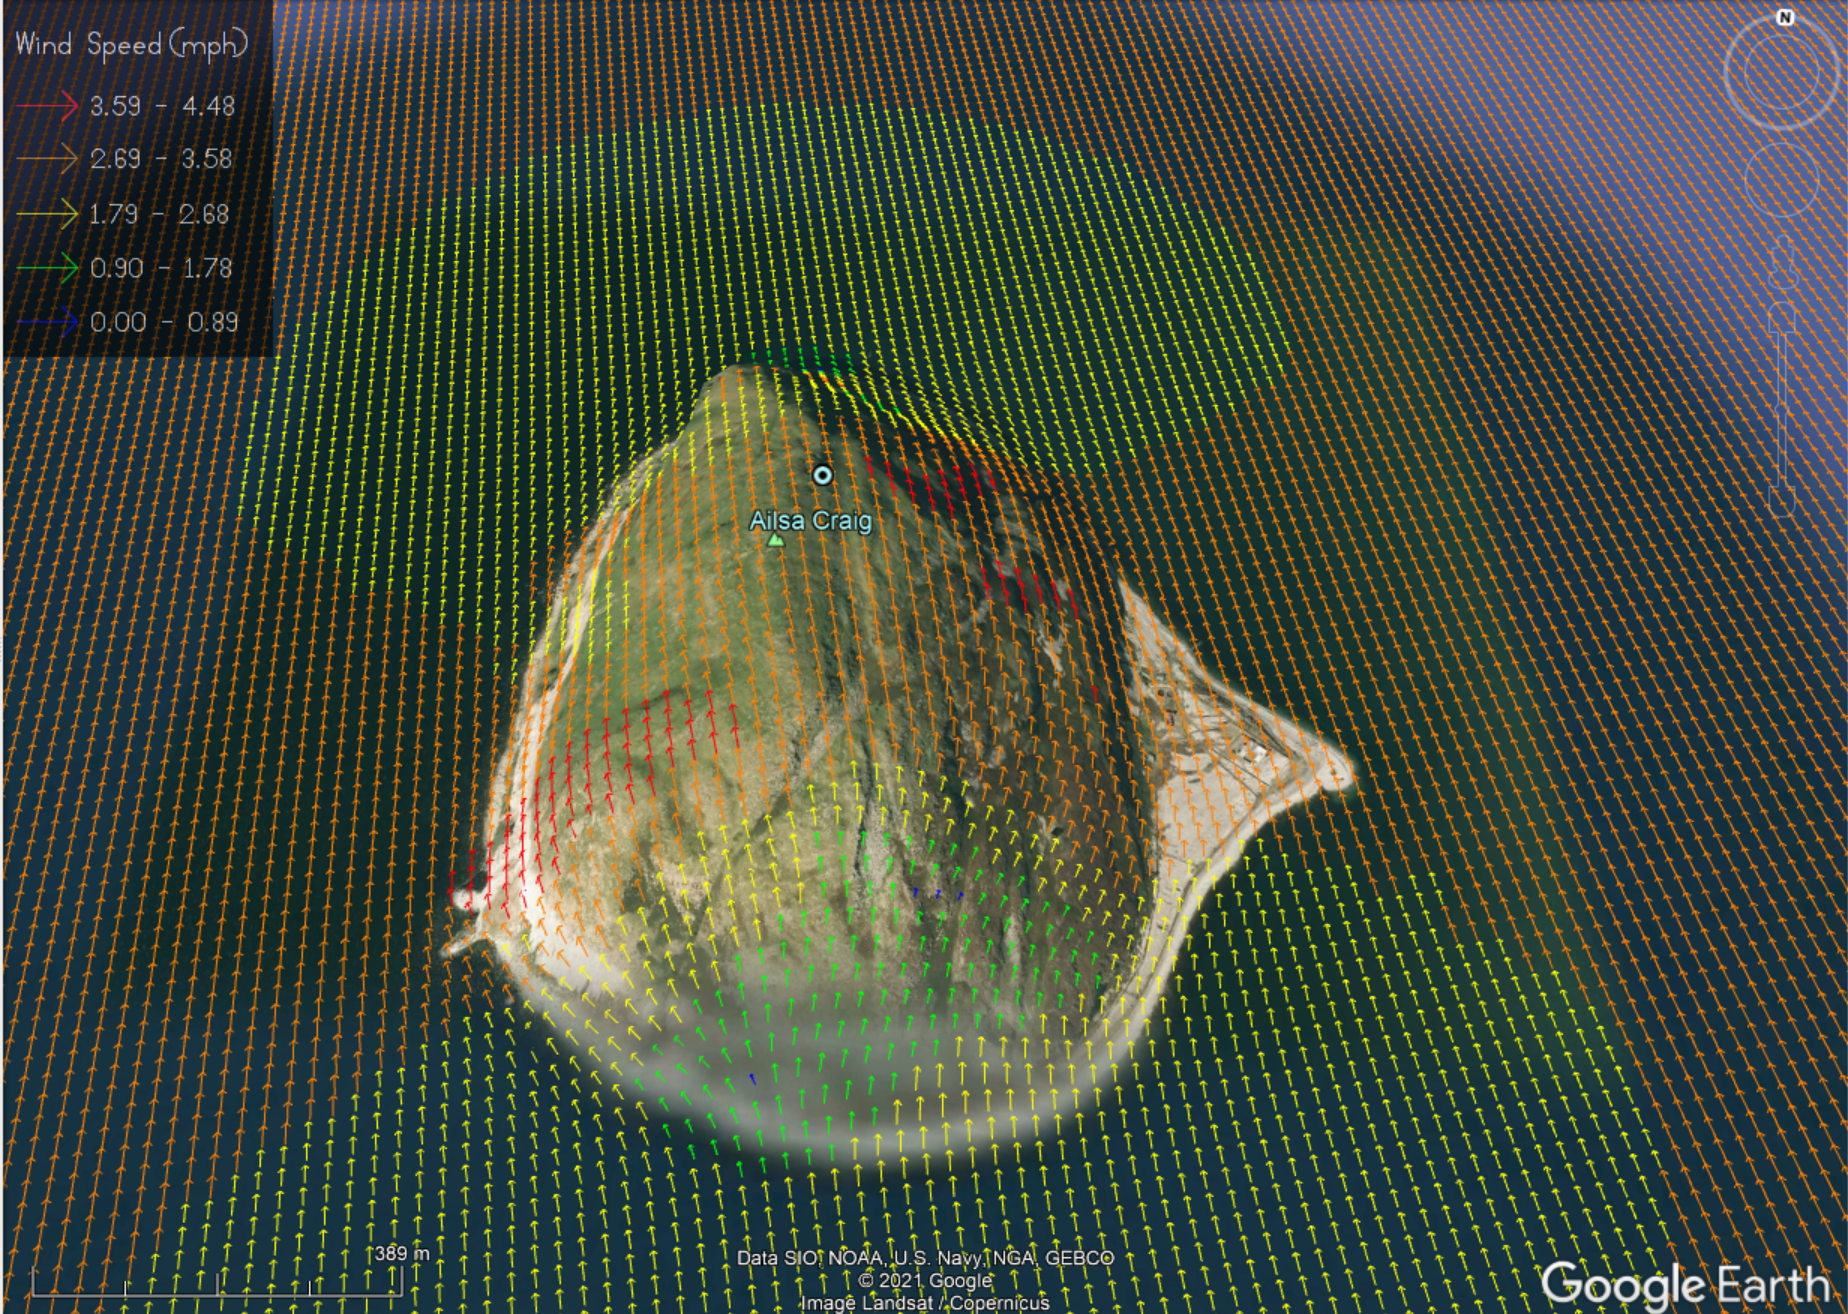